In [1]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

In [2]:
import torch
import torch.nn as nn

/opt/anaconda3/envs/dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from nn import VAE

---

### DATA

In [4]:
def fetch(url):
    import os, requests, gzip, hashlib, numpy
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [5]:
ds = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0
print('Min:', np.min(ds), 'Max:', np.max(ds))

Min: 0.0 Max: 1.0


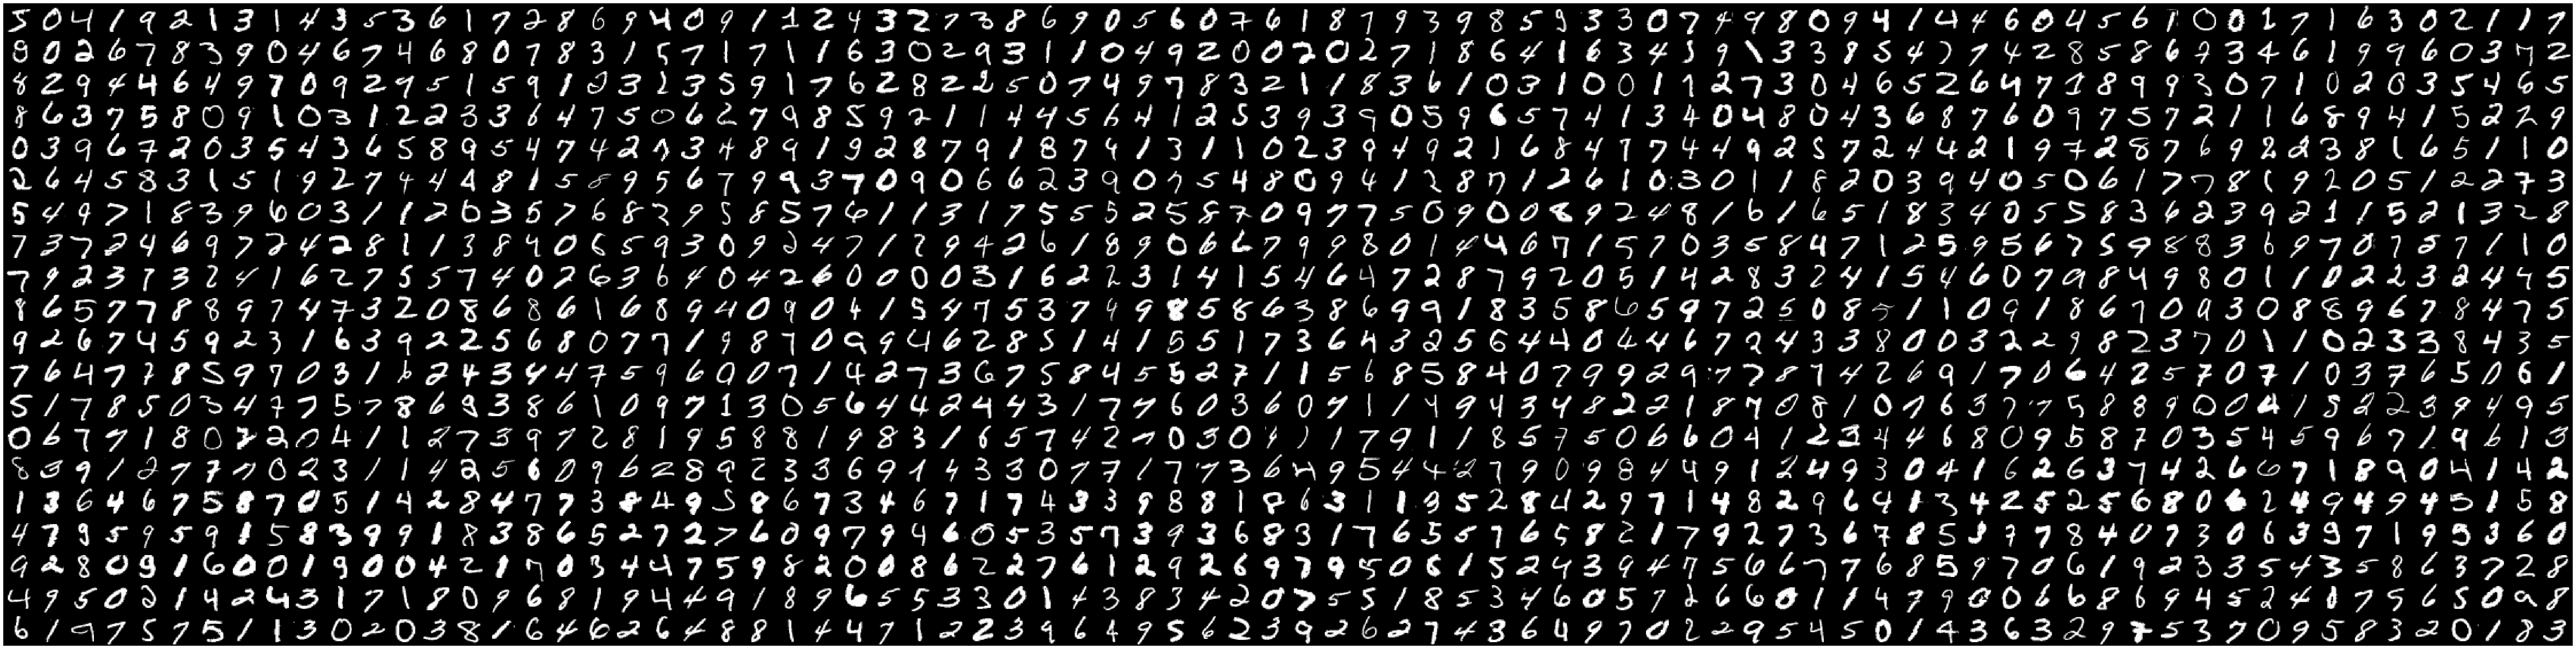

In [6]:
result = np.concatenate([np.concatenate(ds[i*80:(i+1)*80], axis=1) for i in range(20)])

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off')
plt.tight_layout()

---

### TRAINING

In [7]:
model = VAE()

parameters = model.parameters()
print("Nparams:", sum(p.nelement() for p in parameters))
print(model.eval())

Nparams: 1068820
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
# Kullback–Leibler (KL) divergence
def loss_function(x_hat, x, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

In [9]:
bs = 128
lr = 0.001
simlen = 10000

optim = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
lossi = []

for i in (t := trange(simlen)):

    idx = np.random.randint(0, ds.shape[0], size=bs)
    x = torch.tensor(ds[idx].reshape((-1,28*28))).float()

    model.zero_grad()

    x_hat, mean, log_var = model(x)
    loss = loss_function(x_hat, x, mean, log_var)
    loss.backward()
    optim.step()

    lossi.append(loss.item())

    t.set_description(f"Epoch: {i} | Loss: {loss.item():.2f}")

Epoch: 9999 | Loss: 17320.67: 100%|██████████| 10000/10000 [04:49<00:00, 34.58it/s]


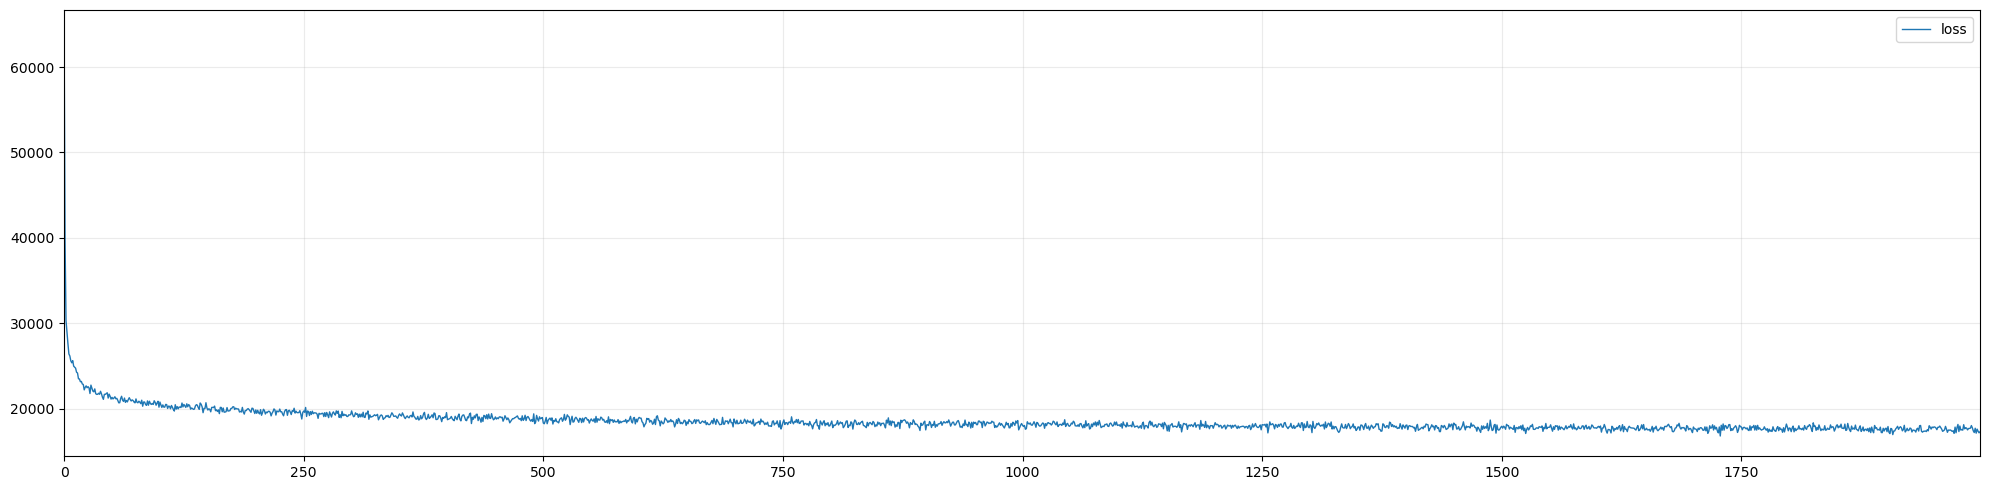

In [11]:
avg_loss = torch.tensor(lossi).view(-1, 5).mean(1)

plt.figure(figsize=(20,5))
plt.plot(avg_loss, lw=1, label='loss')
plt.xlim(0, len(avg_loss)-1)
plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### INFERENCE

In [12]:
def digit(model, mean, var):
    z = torch.tensor([[mean, var]], dtype=torch.float)
    return model.decode(z).detach().reshape(28, 28)

((-0.5, 27.5, 27.5, -0.5), None)

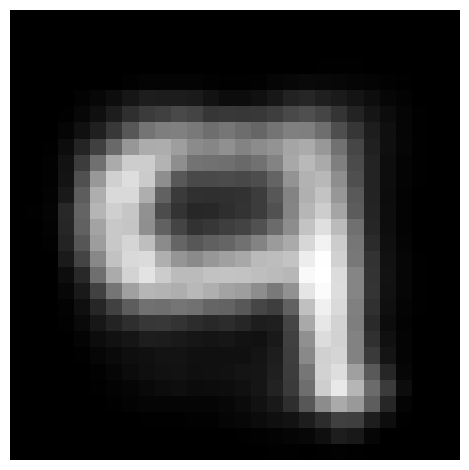

In [15]:
sample = digit(model, 0.0, 0.0)

plt.imshow(sample, 'gray')
plt.axis('off'), plt.tight_layout()

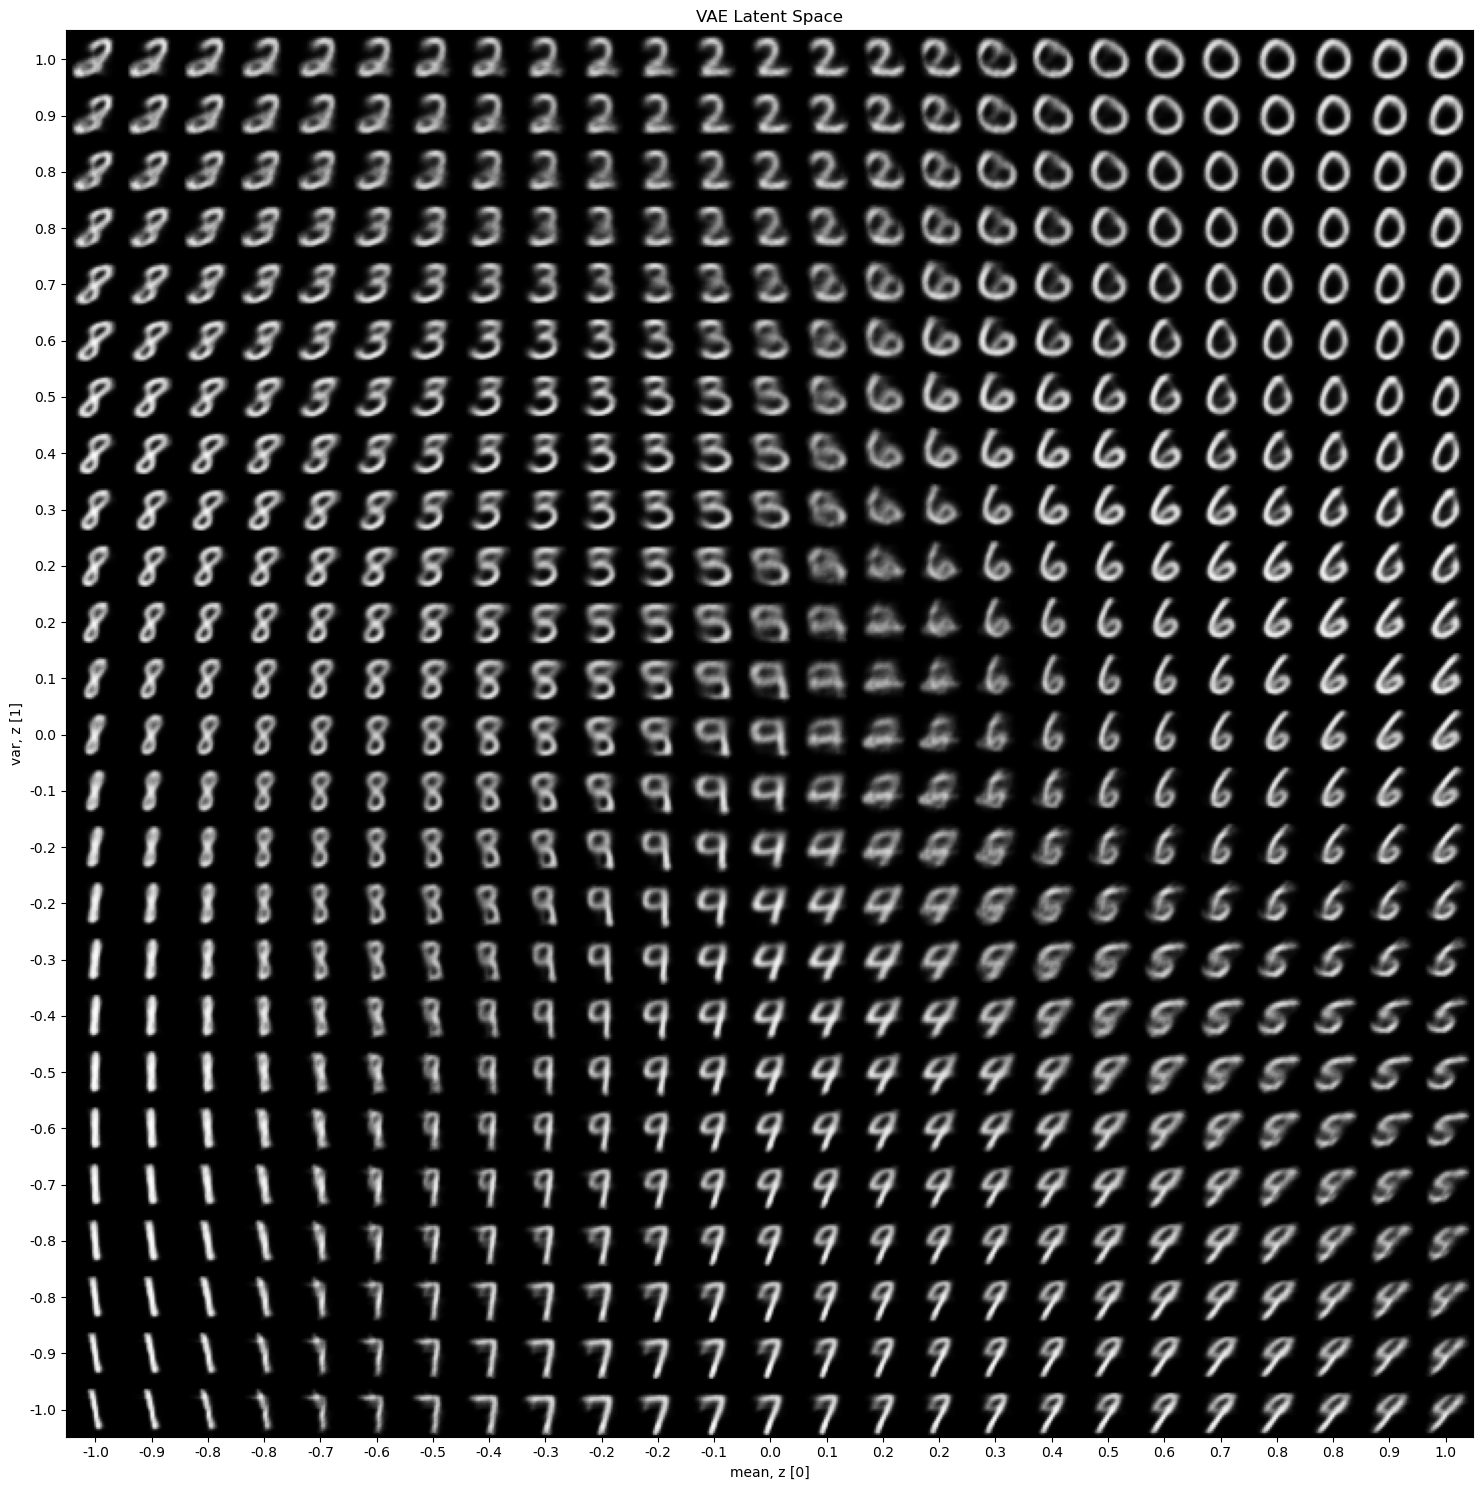

In [16]:
scale = 1.0
n = 25
dim = 28

canvas = np.zeros((dim * n, dim * n))
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim,] = digit(model, xi, yi)

plt.figure(figsize=(15, 15))
plt.imshow(canvas, cmap="gray")
plt.title('VAE Latent Space')
start_range = dim // 2
end_range = n * dim + start_range
pixel_range = np.arange(start_range, end_range, dim)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("mean, z [0]"), plt.ylabel("var, z [1]")
plt.tight_layout()